# Выявление особенностей словоупотребления в текстах Л. Н. Толстого методами дистрибутивной семантики

** TO DO **

- обучить сегментатор поточнее

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

In [ ]:
from lxml import etree
from pymystem3 import Mystem
import string
import nltk
from datetime import datetime
mystem = Mystem()

In [3]:
from numpy import nan
import numpy as np
import pandas as pd
from random import sample
from sklearn.metrics import accuracy_score

In [4]:
from scipy.stats import kendalltau, spearmanr,pearsonr

In [5]:
import gensim

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

## Сегментатор

In [5]:
language_punkt_vars = nltk.tokenize.punkt.PunktLanguageVars
language_punkt_vars.sent_end_chars=('.','?','!','»','…')
with open('.\\data\\traindata.txt', 'r', encoding='utf-8') as f:
    traindata = f.read()
trainer = nltk.tokenize.punkt.PunktTrainer(traindata, language_punkt_vars)
trainer.INCLUDE_ALL_COLLOCS = True 
trainer.INCLUDE_ABBREV_COLLOCS = True
params = trainer.get_params()
sbd = nltk.tokenize.punkt.PunktSentenceTokenizer(params)

  Abbreviation: [1.4849] ст
  Abbreviation: [4.0363] н
  Abbreviation: [1.4849] ул
  Abbreviation: [8.0726] м
  Abbreviation: [5.4625] тыс
  Abbreviation: [5.9395] т.п
  Abbreviation: [19.3033] см
  Abbreviation: [0.5463] стр
  Abbreviation: [1.4849] кн
  Abbreviation: [4.0363] д
  Abbreviation: [1.0925] руб
  Abbreviation: [4.0363] п
  Abbreviation: [0.6029] матф
  Abbreviation: [4.0363] г
0.000380517503805175 0.007662835249042145 0.0 5256 261 2 2
0.000380517503805175 0.007662835249042145 0.0 5256 261 2 2
0.0030441400304414 0.007662835249042145 0.0028028028028028026 5256 261 16 2
0.009512937595129375 0.038314176245210725 0.008008008008008008 5256 261 50 10
0.0030441400304414 0.007662835249042145 0.0028028028028028026 5256 261 16 2
0.001141552511415525 0.007662835249042145 0.0008008008008008008 5256 261 6 2
0.0036149162861491627 0.007662835249042145 0.0034034034034034033 5256 261 19 2
0.00076103500761035 0.007662835249042145 0.0004004004004004004 5256 261 4 2
0.0015220700152207 0.02298

## Данные

На основе 90-томного собрания сочинений

Namespace тегов

In [6]:
tei_ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

Знаки пунктуации для удаления

In [7]:
string.punctuation = string.punctuation.replace('-','')
string.punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

## Функции предобработки

#### Функция для парсинга одного файла.

- ** Вход : ** имя файла
- ** Дополлнительные сведения : ** теги для удаления и исключения, пространство имен тегов получает из пространства имен (области видимости) выше по уровню
- ** Выход : ** нужный текст

In [8]:
def get_one_writing(filename):
    global tei_ns
    root = etree.parse(filename)#.getroot()
    for i in tags_for_deletion:
        for j in root.findall(i, tei_ns):
            parent = j.find("..")
            parent.remove(j)
    for i in tags_to_strip:
        etree.strip_tags(root, i)
    return root.find(".//tei:text", tei_ns).text.strip()

#### Функция для препроцессинга текста

- ** Вход : ** текст, файл записи
- ** Дополнительная информация : ** сегментатор, Mystem - глобальные переменные
- ** Выход : ** количество предложений (для вывода и отслеживания)


** Ход преобразований **

1. Исключение множественных пробелов и переносов строки
2. Деление на предложения
3. Объединение с разделителем в виде $$, так как mystem быстрее работает при одном вызове на большой файл, чем на маленьких частях. И такой знак не встречается в текстах
4. Удаляем [], в которых в текстах восстановлены сокращения
5. Лемматизируем с помощью mystem
6. Удаляем некириллические символы (удаляем нерусский текст, знаки препинания (кроме дефисов), оставляем наши разделители
7. Удаялем возможные множественные дефисы
8. Удаляем остатки от слов типа 8-го (-го).
9. Восстанавливаем разбиение на предложения
10. Если от строки осталось более 25 символов (удаляем слишком маленькие предложения и строки, которые у нас отделяются со ссылками типа (Лука, VII), то записываемв файл.

In [9]:
def preprocessing(text, f):
    global sbd, mystem
    text = re.sub('[\n\s]+',' ', text)
    lng = len(sbd.sentences_from_text(text, realign_boundaries=True))
    text = ' $$ '.join(sbd.sentences_from_text(text, realign_boundaries=True))
    text = text.replace('[','').replace(']','')
    text = ''.join(mystem.lemmatize(text.strip()))
    text = re.sub('[^а-яА-Я\-$ ]','', text)
    text = re.sub('[-]{2,}','', text)
    text = re.sub('[^а-яА-Я]-.*? ',' ', text)
    text = text.split('$$')
    for i in text:
        if len(i.strip())>25:
            f.write(i.strip()+'\n')
    return lng

In [10]:
with open ('1.txt', 'w') as f:
    preprocessing ('Я 1-го числа никак не приду к вам.\n\nЗасим удаляюсь.', f)

#### Функция объединяющая преобразования

- ** Вход : ** путь к папке с данными, тэги для удаления, теги для опущения, имя файла записи, параметр печати логов

** Печать **

- если установлен флажок печати, то печатает: количество предложений в тексте, размер файла (для проверки), время обработки файла, имя файла
- общее время работы

In [11]:
def universal_preprocessing(path, 
                            tags_for_deletion, 
                            tags_to_strip, 
                            filename, printing=True):
    #tags_for_deletion = tags_for_deletion
    #tags_to_strip = tags_to_strip
    #mystem = Mystem()
    start_gen = datetime.now()
    with open (filename, 'w', encoding='utf-8') as f:
        for root, dirs, files in os.walk (path):
                for fl in files :
                    start = datetime.now() 
                    lng = preprocessing(get_one_writing(root+'\\'+fl), f)
                    if printing:
                        print ('{}\t{}\t{}\t{}'.format(lng, os.path.getsize(root+'\\'+fl)//1024, 
                                              datetime.now()-start,
                                              fl))
    print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))
    

### Произведения

Удаляем ненужные комментарии (заметки, пояснения, старые формы, где есть исправления, элементы таблицы). Убираем теги, которые не несут информации, чтобы объединить в единый массив текста.

In [12]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb']

НЕ ЗАПУСКАТЬ!!!

In [13]:
path = '.\\data\\Final\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'writings.txt')

938	125	0:00:02.182899	Abrégé de l’Evangile 24.xml
21	8	0:00:01.690339	AMOUR DE LA PATRIE 1.xml
70	37	0:00:01.979403	Carthago delenda est 39.xml
87	32	0:00:01.801238	Carthago delenda est. Черновое 39.xml
322	95	0:00:02.451469	Letter to a Hindoo (Письмо к индусу) 37.xml
44	13	0:00:01.980461	NOTES SUR LE SECOND CHAPITRE DES «CARACTÈRES» DE LA BRUYÈRE 1.xml
28	13	0:00:02.084049	The hostelry (Гостиница) 37.xml
19	19	0:00:02.041133	[Carthago delenda est] («Жизнь, та форма жизни»...) 27.xml
9	5	0:00:01.725240	[LE PRÉSENT, LE PASSÉ ET LE FUTUR] 1.xml
9	9	0:00:01.620498	[«Давно позабыл я о счастьи ...»] 1.xml
49	29	0:00:01.531272	[«Дядинька Жданов и кавалер Чернов»] 3.xml
60	42	0:00:01.624674	[«Ежели бы человек не желал…»] 1.xml
18	12	0:00:01.594855	[«Ей, Марьяна, брось работу!..»] 1.xml
37	22	0:00:01.562201	[«Знание музыки - субъективное и объективное...»] 1.xml
728	330	0:00:02.259206	[«Начала» романа «Сто лет»] 17.xml
370	203	0:00:02.007993	[«Начала» романа времен Петра I. Азовские походы] 1

### Письма

Добавляются теги <opener> и <closer> как элементы письма, которые не относятся к непосредственному текксту.

In [16]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table',
                      './/tei:opener', './/tei:closer']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [17]:
path = '.\\data\\LETTERS\\'
for root, dirs, files in os.walk (path):
    for fl in files :
        with open (root+'\\'+fl, 'r', encoding='utf-8') as f:
            s = f.read()
            s = re.sub('<note.*?>', '<note>', s)
            s = re.sub('xml:id=".*?"','',s)
        with open (root+'\\'+fl,'w', encoding='utf-8') as f:
            f.write(s)

In [18]:
path = '.\\data\\LETTERS\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'letters.txt', printing=False)



total time:		 3:40:50.729214


### Дневники

In [14]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table', './/tei:opener']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [15]:
path = '.\\data\\diaries\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'diaries.txt')

845	981	0:00:02.302519	46.xml
522	698	0:00:02.069947	47.xml
2673	268	0:00:02.784657	48.xml
4699	425	0:00:03.677143	49.xml
6190	778	0:00:05.672677	50.xml
3502	441	0:00:03.856642	51.xml
3827	612	0:00:04.726578	52.xml
4718	897	0:00:06.313160	53.xml
1582	752	0:00:03.274821	54.xml
2210	1117	0:00:03.734177	55.xml
2574	639	0:00:03.960775	56.xml
2833	733	0:00:03.887149	57.xml
2451	568	0:00:02.797811	58.xml


total time:		 0:00:49.060039


## Соединить источники

In [19]:
files = ['writings.txt', 'letters.txt', 'diaries.txt']
with open ('full_collection.txt', 'w',encoding = 'utf-8') as outp:
    for file in files:
        with open (file, 'r', encoding = 'utf-8') as inp:
            for line in inp:
                outp.write(line)

## Референтный корпус

In [23]:
path = '.\\data\\nkrya\\'
start_gen = datetime.now()
with open ('nkrya.txt', 'w', encoding='utf-8') as f:
    for root, dirs, files in os.walk (path):
        for fl in files :
            with open (root+'\\'+fl, 'r', encoding='utf-8') as inp:
                text = re.sub('\{.*?\}','', inp.read())
                lng = preprocessing(text, f)
print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))



total time:		 3:03:55.088993


## Все модели

Так как данные имеют большой размер, подаем на вход объект, считываемыц из файла (с возможностью итерации без хранения в памяти)

In [2]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya.txt')

### Word2Vec

** CBOW **

In [4]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_W2V_CBOW.save("./models/Tolstoy_W2V_CBOW.model")
print(Tolstoy_W2V_CBOW)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [5]:
NKRYA_W2V_CBOW = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_W2V_CBOW.save("./models/NKRYA_W2V_CBOW.model")
print(NKRYA_W2V_CBOW)

Word2Vec(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [6]:
Tolstoy_W2V_SG = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_W2V_SG.save("./models/Tolstoy_W2V_SG.model")
print(Tolstoy_W2V_SG)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [9]:
NKRYA_W2V_SG = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_W2V_SG.save("./models/NKRYA_W2V_SG.model")
print(NKRYA_W2V_SG)

Word2Vec(vocab=55217, size=300, alpha=0.025)


### FastText

** CBOW **

In [10]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_FT_CBOW.save("./models/Tolstoy_FT_CBOW.model")
print(Tolstoy_FT_CBOW)

FastText(vocab=33439, size=300, alpha=0.025)


In [3]:
NKRYA_FT_CBOW = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_FT_CBOW.save("./models/NKRYA_FT_CBOW.model")
print(NKRYA_FT_CBOW)

FastText(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [12]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG.save("./models/Tolstoy_FT_SG.model")
print(Tolstoy_FT_SG)

FastText(vocab=33439, size=300, alpha=0.025)


In [13]:
NKRYA_FT_SG = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG.save("./models/NKRYA_FT_SG.model")
print(NKRYA_FT_SG)

FastText(vocab=55217, size=300, alpha=0.025)


** Загрузка всех моделей **

In [11]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Tolstoy_W2V_SG = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_SG.model")
NKRYA_W2V_SG = gensim.models.Word2Vec.load("./models/NKRYA_W2V_SG.model")

In [17]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_CBOW.model")
NKRYA_FT_CBOW = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_CBOW.model")
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")

In [12]:
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

## Сравнение

### Simlex

In [5]:
simlex = pd.read_csv('./data/ru_simlex965.tsv', sep='\t')

In [6]:
simlex.columns = ['Word1','Word2','Score_SL']
simlex['Score_SL'].dtype

dtype('float64')

In [7]:
a = list(simlex['Word1'])
b = list(simlex['Word2'])
simlex_words = list(zip(a,b))

In [8]:
def model_result(words,model):
    try:
        result =  model.wv.similarity(words[0], words[1])
        return result
    except:
        return nan

In [ ]:
models = [Tolstoy_W2V_CBOW, NKRYA_W2V_CBOW, Tolstoy_W2V_SG, NKRYA_W2V_SG,
          Tolstoy_FT_CBOW, NKRYA_FT_CBOW, Tolstoy_FT_SG, NKRYA_FT_SG,
          Araneum_FT_CBOW, Araneum_FT_SG]
model_names = ['Tolstoy_W2V_CBOW', 'NKRYA_W2V_CBOW', 'Tolstoy_W2V_SG', 'NKRYA_W2V_SG',
          'Tolstoy_FT_CBOW', 'NKRYA_FT_CBOW', 'Tolstoy_FT_SG', 'NKRYA_FT_SG',
          'Araneum_FT_CBOW', 'Araneum_FT_SG']
all_models = list(zip(models,model_names))

In [14]:
all_models

[(<gensim.models.word2vec.Word2Vec at 0x23487a10fd0>, 'Tolstoy_W2V_CBOW'),
 (<gensim.models.word2vec.Word2Vec at 0x2348a6744a8>, 'NKRYA_W2V_CBOW'),
 (<gensim.models.word2vec.Word2Vec at 0x234923fdcc0>, 'Tolstoy_W2V_SG'),
 (<gensim.models.word2vec.Word2Vec at 0x234923fdeb8>, 'NKRYA_W2V_SG'),
 (<gensim.models.fasttext.FastText at 0x23487a20550>, 'Tolstoy_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x234923fddd8>, 'NKRYA_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x234a113c860>, 'Tolstoy_FT_SG'),
 (<gensim.models.fasttext.FastText at 0x234a113c710>, 'NKRYA_FT_SG'),
 (<gensim.models.fasttext.FastText at 0x2348a5212b0>, 'Araneum_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x235e57cd128>, 'Araneum_FT_SG')]

In [13]:
for i in all_models:
    simlex[i[1]] = np.apply_along_axis(model_result, 1, arr = simlex_words, model = i[0] )

In [14]:
simlex.head()

,Word1,Word2,Score_SL,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,авария,бедствие,6.15,0.315040,0.312024,0.458422,0.383732,0.366403,0.401920,0.387836,0.423720,0.417583,0.532138
1,август,месяц,2.85,0.517988,0.390630,0.473710,0.403803,0.552756,0.394618,0.513207,0.400371,0.365336,0.538927
2,авиация,полет,6.77,NaN,NaN,NaN,NaN,0.315683,0.418777,0.336305,0.353902,0.369196,0.480803
3,автомобиль,гудок,1.85,NaN,NaN,NaN,NaN,0.309600,0.287628,0.541232,0.209126,0.052265,0.259283
4,автомобиль,автострада,1.23,NaN,NaN,NaN,NaN,0.287549,0.612199,0.642494,0.515194,0.521806,0.449036


In [15]:
simlex_short = simlex.dropna()

In [17]:
for i in all_models:
    print ('{}\t\t{}'.format(i[1], spearmanr(simlex_short[i[1]], simlex_short['Score_SL'])[0]))

Tolstoy_W2V_CBOW		-0.02312097810078662
NKRYA_W2V_CBOW		0.2728283340461548
Tolstoy_W2V_SG		0.13547678929311274
NKRYA_W2V_SG		0.3180245293198616
Tolstoy_FT_CBOW		0.10480719946239418
NKRYA_FT_CBOW		0.24098530695427278
Tolstoy_FT_SG		0.15588363327276267
NKRYA_FT_SG		0.27768484342806704
Araneum_FT_CBOW		0.3220139240500222
Araneum_FT_SG		0.3263901137902892


** Пропорции **

** семья **

In [18]:
family = pd.read_csv('./data/ru_analogy_family.txt', sep=' ', header=None)
family.columns = ['Word1','Word2','Word3','Result']

In [19]:
family.head()

,Word1,Word2,Word3,Result
0,мальчик,девочка,брат,сестра
1,мальчик,девочка,братья,сестры
2,мальчик,девочка,папа,мама
3,мальчик,девочка,отец,мать
4,мальчик,девочка,дед,бабка


In [20]:
a = list(family['Word1'])
b = list(family['Word2'])
c = list(family['Word3'])
family_words = list(zip(a,b,c))

In [21]:
def proportion(words,model):
    #print (words)
    try:
        result = model.wv.most_similar(positive=[words[0], words[1]], negative=[words[2]])[0][0]
        return result
    except:
        return nan

In [22]:
for i in all_models:
    family[i[1]] = [proportion(words, i[0]) for words in family_words]

In [25]:
family.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,мальчик,девочка,брат,сестра,кукла,мальчуган,девушка,девушка,девчонка,мальчишечка,кмальчик,девочка-подросток,пай-девочка,девчушка
1,мальчик,девочка,братья,сестры,девушка,мальчуган,девушка,мальчуган,кмальчик,мальчишечка,кмальчик,девочка-подросток,мальчонка,малышка
2,мальчик,девочка,папа,мама,юноша,мальчуган,двойня,мальчуган,мальчик-сын,мальчонка,кмальчик,девочка-подросток,мальчонка,девчушка
3,мальчик,девочка,отец,мать,баба,мальчуган,девушка,мальчуган,девчонка,мальчишечка,кмальчик,мальчишечка,пай-девочка,девчушка
4,мальчик,девочка,дед,бабка,девушка,мальчуган,девушка,девушка,мальчишка,мальчишечка,кмальчик,мальчишечка,пай-девочка,малышка


In [30]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(family['Result']),list(family[i[1]])))

Tolstoy_W2V_CBOW 	 0.0
NKRYA_W2V_CBOW 	 0.003952569169960474
Tolstoy_W2V_SG 	 0.0
NKRYA_W2V_SG 	 0.005928853754940711
Tolstoy_FT_CBOW 	 0.0
NKRYA_FT_CBOW 	 0.0
Tolstoy_FT_SG 	 0.0
NKRYA_FT_SG 	 0.0
Araneum_FT_CBOW 	 0.0
Araneum_FT_SG 	 0.0


** Прилагательные/наречия **

In [31]:
adj_adv = pd.read_csv('./data/ru_analogy_adj-adv.txt', sep=' ', header=None)
adj_adv.columns = ['Word1','Word2','Word3','Result']

In [32]:
a = list(adj_adv['Word1'])
b = list(adj_adv['Word2'])
c = list(adj_adv['Word3'])
adj_adv_words = list(zip(a,b,c))

In [33]:
for i in all_models:
    adj_adv[i[1]] = [proportion(words, i[0]) for words in adj_adv_words]

In [34]:
adj_adv.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,удивительный,удивительно,очевидный,очевидно,ах,чудно,прелестный,прелестно,презрительно,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенно
1,удивительный,удивительно,спокойный,спокойно,глупо,замечательный,неважно,замечательный,значительно,неудивительный,неудивительный,неудивительный,поразительно,поразительный
2,удивительный,удивительно,веселый,весело,доказываться,поразительный,гадание,изумительный,неосновательно,неудивительный,неудивительный,неудивительный,поразительный,поразительный
3,удивительный,удивительно,страшный,страшно,умно,замечательно,умно,замечательно,одобрительно,замечательно,неудивительный,неудивительный,необычайно,необыкновенно
4,удивительный,удивительно,эффективный,эффективно,NaN,NaN,NaN,NaN,неудивительный,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенный


In [41]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(adj_adv['Result']),list(adj_adv[i[1]])))

Tolstoy_W2V_CBOW 	 0.00221606648199446
NKRYA_W2V_CBOW 	 0.000554016620498615
Tolstoy_W2V_SG 	 0.00110803324099723
NKRYA_W2V_SG 	 0.000554016620498615
Tolstoy_FT_CBOW 	 0.000554016620498615
NKRYA_FT_CBOW 	 0.000554016620498615
Tolstoy_FT_SG 	 0.000554016620498615
NKRYA_FT_SG 	 0.00110803324099723
Araneum_FT_CBOW 	 0.000554016620498615
Araneum_FT_SG 	 0.0016620498614958448


## Первый способ : искуственные сдвиги

Для оценки того, что является сдвигом, нужно создать его контролируемо и посмотреть на то, как он будет выглядеть. Нужно определить, какая метрика лучше отражает сдвиг, то есть будет коррелировать с тем, в какой степени мы изменили значение. Для этого заменим часть слов на сходные по частоте.

In [5]:
freq = pd.read_csv('./data/freqrnc2011.csv', sep='\t')

In [6]:
freq.columns = ['Lemma','PoS','Freq','R','D','Doc']

In [7]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
0,а,conj,8198.0,100,97,32332
1,а,intj,19.8,99,90,757
2,а,part,6.1,59,79,128
3,а,s,2.7,59,85,160
4,аа,intj,1.5,47,80,68


In [8]:
freq.shape

(52138, 6)

In [9]:
freq[freq.Freq > 100].shape

(1235, 6)

In [10]:
freq = freq[(freq.Freq > 100) & (freq.Freq < 1000)]
freq.shape

(1145, 6)

In [11]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
192,автомобиль,s,156.9,100,92,3453
207,автор,s,262.1,100,93,6216
462,акт,s,113.6,99,84,2830
465,актер,s,114.4,99,87,1827
533,Александр,s.PROP,237.8,100,91,6592


In [12]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")

In [13]:
vocab = list(set(Tolstoy_W2V_CBOW.wv.vocab) & set(NKRYA_W2V_CBOW.wv.vocab) & set(Araneum_FT_CBOW.wv.vocab) & set(freq['Lemma']))

In [14]:
len(vocab)

934

In [15]:
a = [1,2,3,4,5,6,7,8,9,10]
a[:6:-1]

[10, 9, 8]

In [16]:
word_list = sample(vocab, 600)

In [17]:
list(reversed([1,2,3]))

[3, 2, 1]

In [18]:
Artificial_shifts =pd.DataFrame({
    'Lemma':word_list,
    'Lemma2':list(reversed(word_list[:200]))+list(reversed(word_list[200:400]))+list(reversed(word_list[400:600])), 
    'Q':[0.9]*200+[0.7]*200+[0.5]*200})

In [19]:
Artificial_shifts.head()

,Lemma,Lemma2,Q
0,нога,подходить,0.9
1,страх,тело,0.9
2,хозяин,против,0.9
3,ставить,использовать,0.9
4,нормальный,голос,0.9


In [20]:
Artificial_shifts.to_csv('./data/art_shifts.csv', sep='\t', index=False, encoding='utf-8')

Загружаем

In [31]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [32]:
Artificial_shifts = Artificial_shifts.set_index('Lemma')

In [38]:
Artificial_shifts['target'] = Artificial_shifts['Q']*10

Artificial_shifts['T_counter'] = [0]*600
Artificial_shifts['T_changed'] = [0]*600
Artificial_shifts['T_total'] = [0]*600

Artificial_shifts['19_counter'] = [0]*600
Artificial_shifts['19_changed'] = [0]*600
Artificial_shifts['19_total'] = [0]*600

In [60]:
10 > 9.0

True

In [34]:
lemma = set(Artificial_shifts.index)

In [55]:
5 // 2

2

In [39]:
with open ('full_collection.txt', 'r', encoding = 'utf-8') as inp:
    with open ('full_collection_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['T_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                        Artificial_shifts.set_value(i, 'T_changed', Artificial_shifts['T_changed'][i] + 1)
                        #if Artificial_shifts['counter'][i] == 10:
                        #    Artificial_shifts.set_value(i, 'counter', 0) 
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                    Artificial_shifts.set_value(i, 'T_total', Artificial_shifts['T_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [42]:
Artificial_shifts['T'] = 1 - Artificial_shifts['T_changed']/Artificial_shifts['T_total']

In [44]:
Artificial_shifts[['Q','T']].corr()

,Q,T
Q,1.000000,0.972824
T,0.972824,1.000000


In [45]:
with open ('nkrya.txt', 'r', encoding = 'utf-8') as inp:
    with open ('nkrya_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['19_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                        Artificial_shifts.set_value(i, '19_changed', Artificial_shifts['19_changed'][i] + 1)
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                    Artificial_shifts.set_value(i, '19_total', Artificial_shifts['19_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [46]:
Artificial_shifts['19'] = 1 - Artificial_shifts['19_changed']/Artificial_shifts['19_total']

In [47]:
Artificial_shifts[['Q','19']].corr()

,Q,19
Q,1.000000,0.999978
19,0.999978,1.000000


In [48]:
Artificial_shifts.to_csv('./data/new_art.csv', sep='\t', index=False, encoding='utf-8')

### Обучим модели и сравним

In [49]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection_shift.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya_shift.txt')

In [50]:
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG_shift.save("./models/Tolstoy_FT_SG_shift.model")
print(Tolstoy_FT_SG_shift)

FastText(vocab=33439, size=300, alpha=0.025)


In [51]:
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG_shift.save("./models/NKRYA_FT_SG_shift.model")
print(NKRYA_FT_SG_shift)

FastText(vocab=55217, size=300, alpha=0.025)


In [16]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG_shift.model")
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG_shift.model")

### Метрики

In [32]:
def Kendall(word, model1, model2, topn=50):
    if word in model1.wv.vocab:
        one = model1.wv.most_similar(word, topn = topn)
    else:
        return nan
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(topn)
        #a = list(a)
        result = kendalltau(list(range(0, topn)), b)[0]
        return result
    else:
        return nan

In [33]:
def Jaccard(word, model1, model2, topn=50):
    try:
        a = model1.wv.most_similar(word, topn = topn)
        b = model2.wv.most_similar(word, topn = topn)
        a = set(list(zip(*a))[0])
        b = set(list(zip(*b))[0])
        return len(a&b) / len (a)
    except:
        return nan

** NDCG **

In [34]:
import math
def find_dcg(element_list):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Discounted Cumulative Gain (DCG)
    Parameters:
        element_list - a list of ranks Ex: [5,4,2,2,1]
    """
    score = 0.0
    for order, rank in enumerate(element_list):
        score += float(rank)/math.log((order+2))
    return score


def find_ndcg(reference, hypothesis):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Parameters:
        reference   - a gold standard (perfect) ordering Ex: [5,4,3,2,1]
        hypothesis  - a proposed ordering Ex: [5,2,2,3,1]
    Returns:
        ndcg_score  - normalized score
    """

    return find_dcg(hypothesis)/find_dcg(reference)

#def get_new_scores(word, model1, model2, topn):
#    one = model1.wv.most_similar(word, topn = topn)
#    a = list(zip(*one))[1]
#    words = list(zip(*one))[0]
#    b = []
#    for i in words:
#        try:
#            b.append(model2.wv.similarity(word, i))
#        except:
#            b.append(0)
#    a = list(a)
#    result = find_ndcg(a,b)
#    return result

def get_new_scores(word, model1, model2, topn=50):
    if word in model1.wv.vocab:
        one = model1.wv.most_similar(word, topn = topn)
    else:
        return nan
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:topn-key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(0)
        #a = list(a)
        result = find_ndcg(list(range(topn, 0, -1)), b)
        return result
    else:
        return nan

In [38]:
list(range(5, 0, -1))

[5, 4, 3, 2, 1]

### Check

In [13]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [35]:
Kendall_vec = np.vectorize(Kendall)
Jaccard_vec = np.vectorize(Jaccard)
ndcg_vec = np.vectorize(get_new_scores)

In [ ]:
Kendall_vec

In [48]:
Jccrd = []
NDCG = []
x = list(range(10,301,10))
for i in x:
    Jccrd.append(pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])
    NDCG.append(pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])

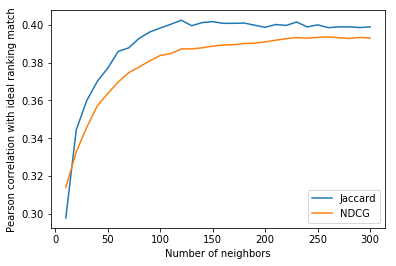

In [49]:
plt.plot(x, Jccrd, label = 'Jaccard')
plt.plot(x, NDCG, label = 'NDCG')
plt.legend(['Jaccard', 'NDCG'])
plt.ylabel('Pearson correlation with ideal ranking match')
plt.xlabel('Number of neighbors')
plt.show()

In [37]:
Jccrd = []
NDCG = []
x = list(range(10,301,10))
for i in x:
    Jccrd.append(pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])
    NDCG.append(pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])

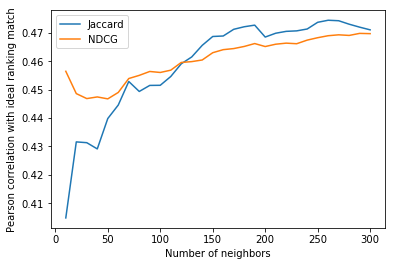

In [44]:
plt.plot(x, Jccrd, label = 'Jaccard')
plt.plot(x, NDCG, label = 'NDCG')
plt.legend(['Jaccard', 'NDCG'])
plt.ylabel('Pearson correlation with ideal ranking match')
plt.xlabel('Number of neighbors')
plt.show()

In [17]:
Artificial_shifts['T_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)
Artificial_shifts['T_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)
Artificial_shifts['T_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)

Artificial_shifts['19_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)
Artificial_shifts['19_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)
Artificial_shifts['19_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)

In [50]:
data = Artificial_shifts[['Q', 'T_Kendall','T_Jaccard','T_NDCG']]
data.corr(method='pearson')

,Q,T_Kendall,T_Jaccard,T_NDCG
Q,1.000000,0.308338,0.401645,0.388679
T_Kendall,0.308338,1.000000,0.851626,0.876627
T_Jaccard,0.401645,0.851626,1.000000,0.985295
T_NDCG,0.388679,0.876627,0.985295,1.000000


In [51]:
data = Artificial_shifts[['Q', '19_Kendall','19_Jaccard','19_NDCG']]
data.corr(method='pearson')

,Q,19_Kendall,19_Jaccard,19_NDCG
Q,1.000000,0.339639,0.468699,0.462985
19_Kendall,0.339639,1.000000,0.847013,0.876704
19_Jaccard,0.468699,0.847013,1.000000,0.985293
19_NDCG,0.462985,0.876704,0.985293,1.000000


In [20]:
pearsonr(Kendall_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 10),
             Artificial_shifts['Q'].values)[0]

C:\Users\Glaz\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


nan

In [52]:
Artificial_shifts['T_m'] = Artificial_shifts['T_Jaccard'].values*Artificial_shifts['T_NDCG'].values
Artificial_shifts['19_m'] = Artificial_shifts['19_Jaccard'].values*Artificial_shifts['19_NDCG'].values

In [53]:
data = Artificial_shifts[['Q', 'T_m', '19_m']]
data.corr(method='pearson')

,Q,T_m,19_m
Q,1.000000,0.415125,0.471812
T_m,0.415125,1.000000,0.766414
19_m,0.471812,0.766414,1.000000


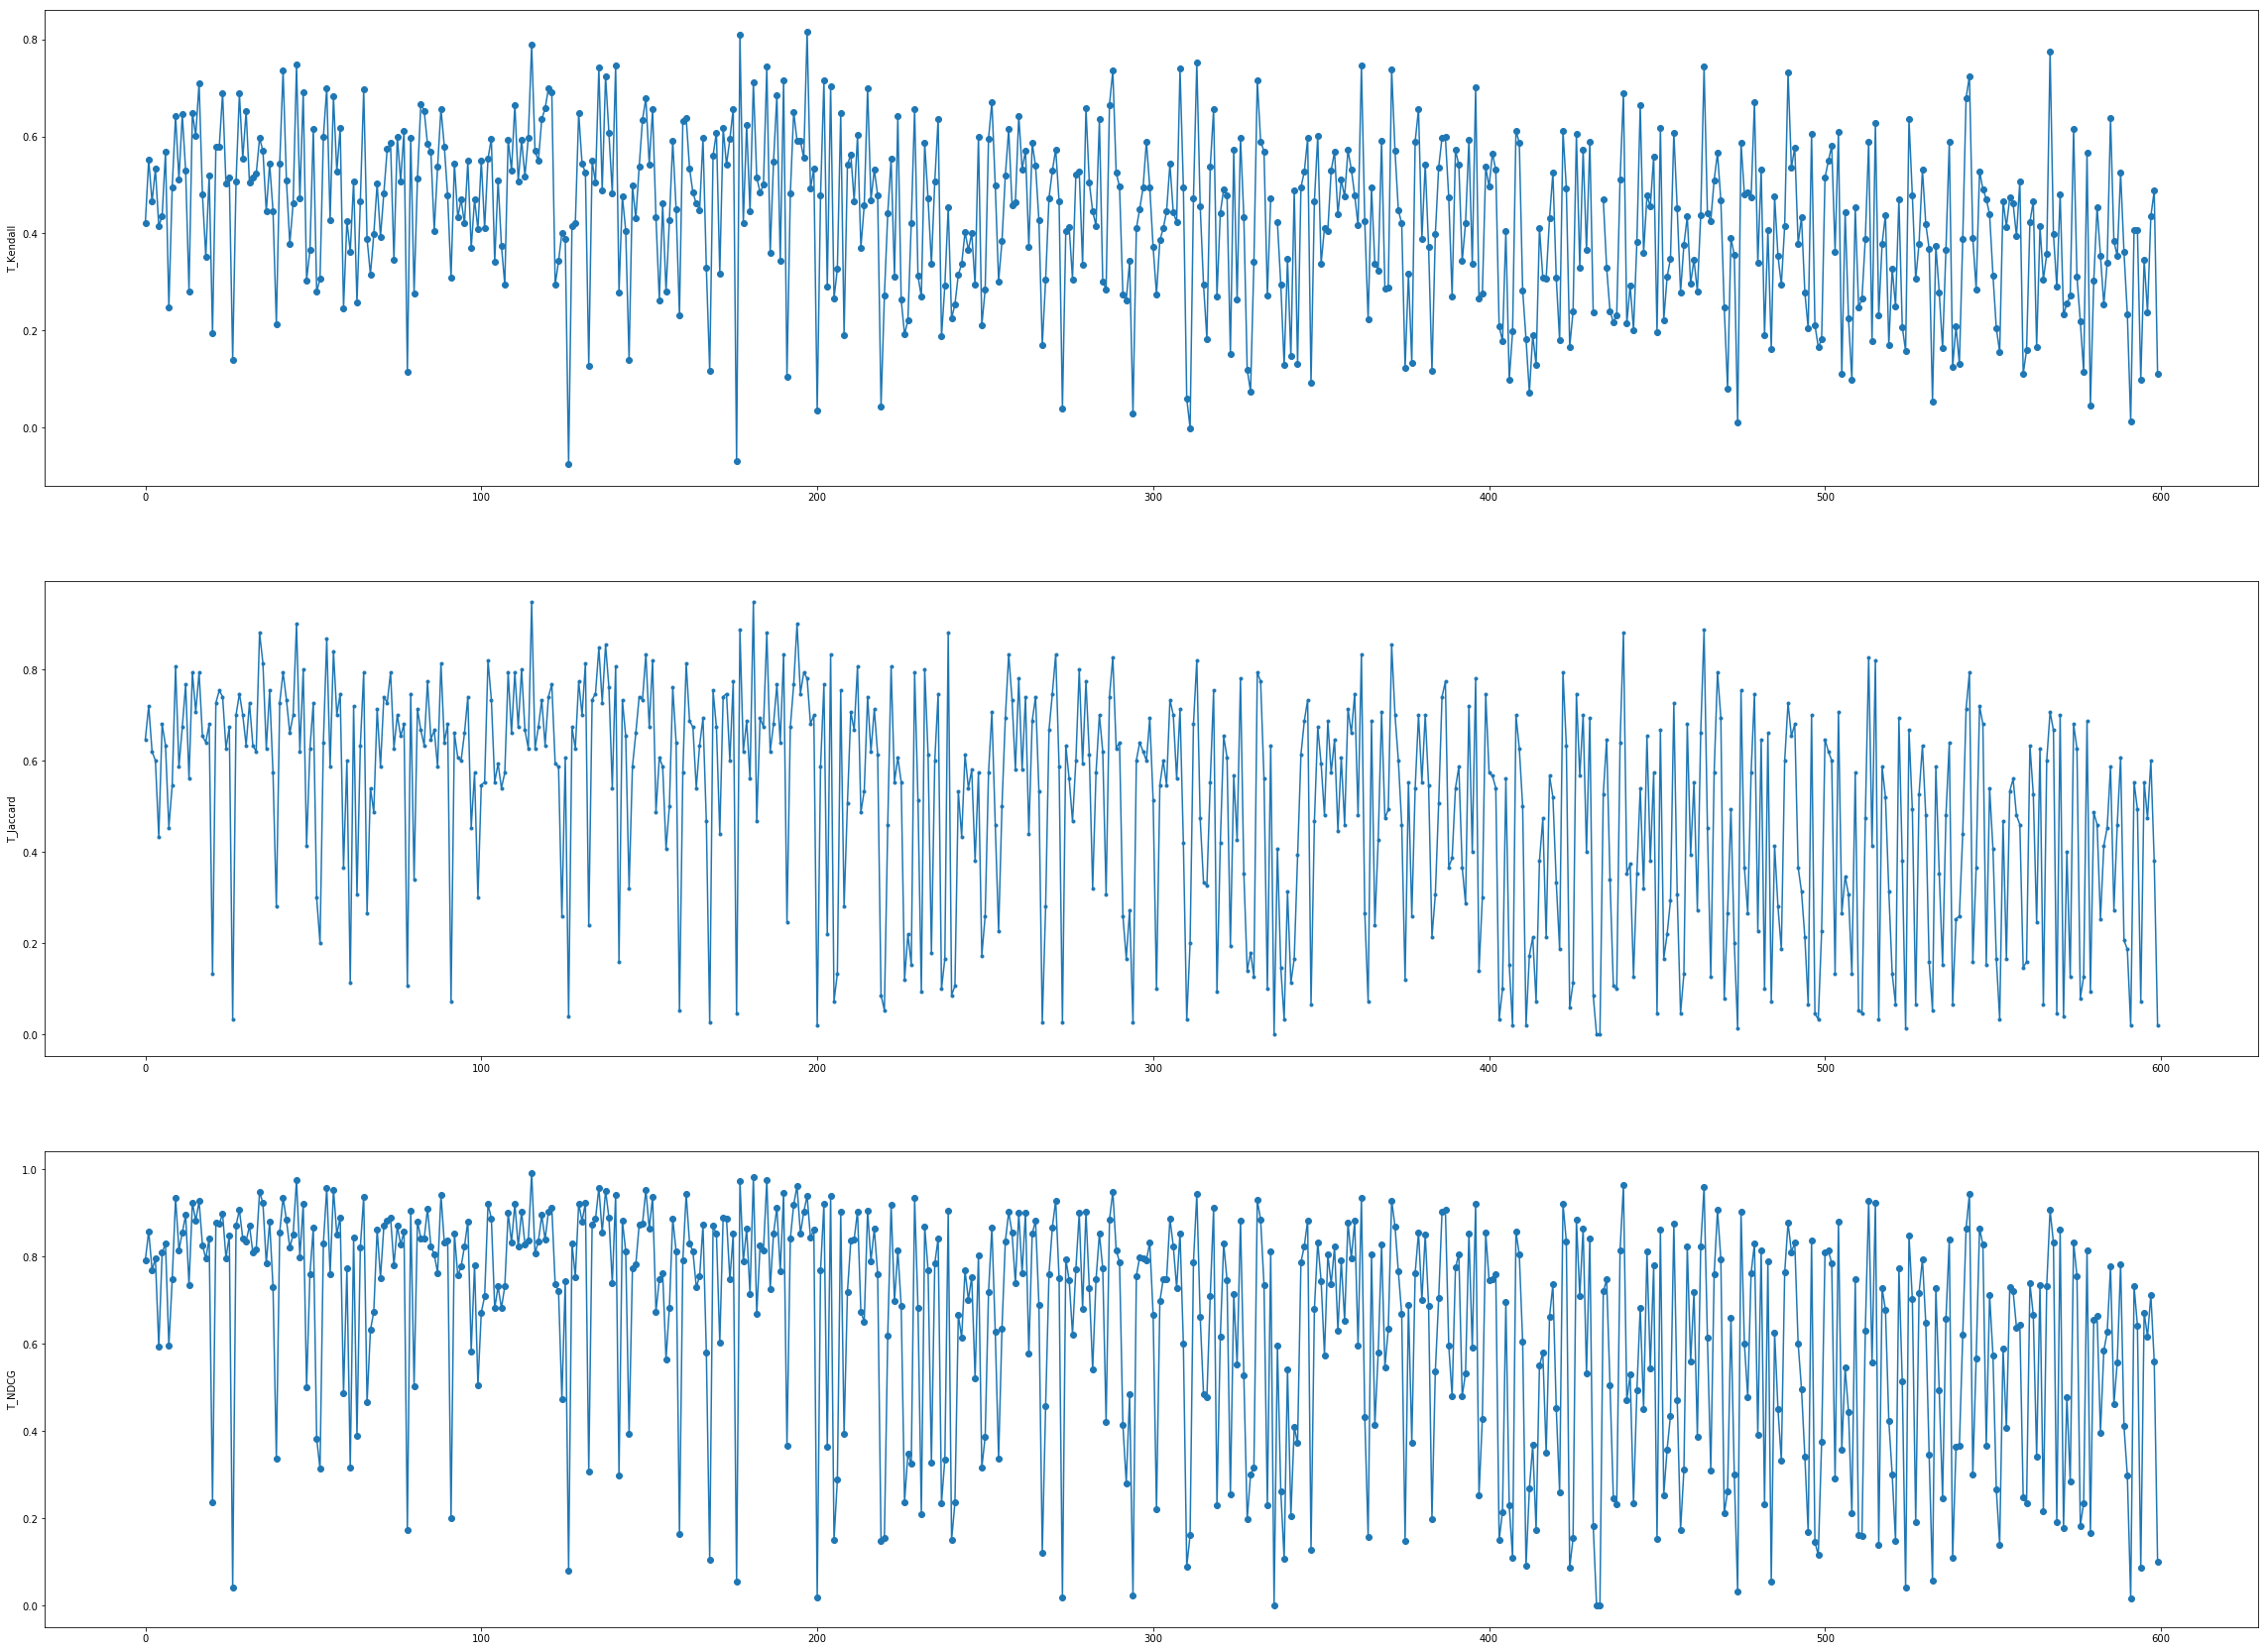

In [54]:
y1 = np.array(Artificial_shifts['T_Kendall'].values)
y2 = np.array(Artificial_shifts['T_Jaccard'].values)
y3 = np.array(Artificial_shifts['T_NDCG'].values)

x = list(range(600))
plt.figure(figsize=(40,30))

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'o-')
#plt.title('A tale of 2 subplots')
plt.ylabel('T_Kendall')

plt.subplot(3, 1, 2)
plt.plot(x, y2, '.-')
#plt.xlabel('time (s)')
plt.ylabel('T_Jaccard')

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'o-')
#plt.title('A tale of 2 subplots')
plt.ylabel('T_NDCG')

plt.show()

In [55]:
Artificial_shifts.head(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m
0,нога,подходить,0.9,0.421949,0.646667,0.791755,0.510476,0.680000,0.849471,0.512002,0.577640
1,страх,тело,0.9,0.552168,0.720000,0.857699,0.596615,0.700000,0.868000,0.617544,0.607600
2,хозяин,против,0.9,0.465192,0.620000,0.769552,0.409537,0.533333,0.712248,0.477122,0.379865
3,ставить,использовать,0.9,0.532878,0.600000,0.794757,0.676411,0.686667,0.849012,0.476854,0.582989
4,нормальный,голос,0.9,0.414697,0.433333,0.593178,0.292312,0.266667,0.432270,0.257044,0.115272
5,прежде,московский,0.9,0.435730,0.680000,0.808372,0.403966,0.400000,0.522071,0.549693,0.208828
6,американский,бить,0.9,0.567363,0.633333,0.829990,0.577185,0.706667,0.857703,0.525660,0.606110
7,вроде,доход,0.9,0.246785,0.453333,0.595704,0.374020,0.440000,0.607982,0.270052,0.267512
8,вместо,разработка,0.9,0.495529,0.546667,0.746885,0.391281,0.440000,0.607095,0.408297,0.267122
9,оставаться,особенность,0.9,0.642746,0.806667,0.933984,0.570020,0.786667,0.899546,0.753414,0.707643


In [56]:
Artificial_shifts.tail(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m
585,большой,автор,0.5,0.637560,0.586667,0.776511,0.589385,0.593333,0.762566,0.455553,0.452456
586,считаться,ветер,0.5,0.383587,0.273333,0.460483,0.261937,0.153333,0.278837,0.125865,0.042755
587,оценка,фонд,0.5,0.353947,0.460000,0.557679,0.276858,0.586667,0.731600,0.256532,0.429205
588,государство,бутылка,0.5,0.524700,0.606667,0.782009,0.441710,0.520000,0.642216,0.474419,0.333953
589,квартира,служба,0.5,0.361646,0.206667,0.410907,0.427875,0.413333,0.570803,0.084921,0.235932
590,сначала,разговор,0.5,0.234052,0.186667,0.298136,0.262906,0.133333,0.193672,0.055652,0.025823
591,актер,ночь,0.5,0.012570,0.020000,0.016335,0.076415,0.033333,0.092219,0.000327,0.003074
592,дерево,принцип,0.5,0.406849,0.553333,0.732012,0.534447,0.680000,0.840252,0.405047,0.571371
593,долго,тихий,0.5,0.406312,0.493333,0.642081,0.497522,0.460000,0.657551,0.316760,0.302474
594,кухня,партия,0.5,0.098401,0.073333,0.085704,0.312178,0.226667,0.266287,0.006285,0.060358


In [29]:
#plt.scatter(Artificial_shifts['Q'], Artificial_shifts['T_LR'])

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
AS = Artificial_shifts.dropna()

In [59]:
Y = AS['Q']

In [60]:
lr = LinearRegression()
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
lr.coef_ 

array([-0.09148474,  0.40502858, -0.07777904])

In [61]:
lr = LinearRegression()
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]#print(x_T.head())
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
lr.coef_ 

array([-0.26561005,  0.20641206,  0.25794476])

In [62]:
AS.head()

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m,T_LR,19_LR
0,нога,подходить,0.9,0.421949,0.646667,0.791755,0.510476,0.680000,0.849471,0.512002,0.577640,0.747290,0.771225
1,страх,тело,0.9,0.552168,0.720000,0.857699,0.596615,0.700000,0.868000,0.617544,0.607600,0.759950,0.757253
2,хозяин,против,0.9,0.465192,0.620000,0.769552,0.409537,0.533333,0.712248,0.477122,0.379865,0.734260,0.732366
3,ставить,использовать,0.9,0.532878,0.600000,0.794757,0.676411,0.686667,0.849012,0.476854,0.582989,0.718007,0.728409
4,нормальный,голос,0.9,0.414697,0.433333,0.593178,0.292312,0.266667,0.432270,0.257044,0.115272,0.676993,0.636240


In [63]:
AS.tail()

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m,T_LR,19_LR
595,рано,специалист,0.5,0.345702,0.553333,0.671649,0.453184,0.586667,0.716130,0.371646,0.420130,0.725805,0.732783
596,весьма,позвонить,0.5,0.238052,0.473333,0.616208,0.551162,0.646667,0.773087,0.291672,0.499929,0.707563,0.733835
597,искать,мешать,0.5,0.435530,0.600000,0.711474,0.495673,0.633333,0.810201,0.426884,0.513127,0.733390,0.755395
598,скоро,странный,0.5,0.487859,0.380000,0.560016,0.520238,0.560000,0.698703,0.212806,0.391274,0.651277,0.704973
599,банк,сложный,0.5,0.110438,0.020000,0.100153,0.379472,0.280000,0.452352,0.002003,0.126659,0.575763,0.621021


In [64]:
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.401204
T_LR,0.401204,1.000000


In [65]:
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.478626
19_LR,0.478626,1.000000


In [66]:
from sklearn.preprocessing import PolynomialFeatures

In [68]:
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_T)
x_T = poly.fit_transform(x_T)

lr = LinearRegression()
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
print(lr.coef_)
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

[ 0.         -0.42344022 -0.04122197 -0.17209688 -0.06924596 -1.75346308
  1.71309737 -0.0347263   1.07709922 -0.33998724]


,Q,T_LR
Q,1.000000,0.434488
T_LR,0.434488,1.000000


In [67]:
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_19)
x_19 = poly.fit_transform(x_19)

lr = LinearRegression()
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
print(lr.coef_)
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

[ 0.         -0.08354053  0.28493008 -0.43649122 -1.14793651 -3.63431775
  3.87238904  1.2019035  -0.09127112 -0.3007706 ]


,Q,19_LR
Q,1.000000,0.515204
19_LR,0.515204,1.000000


In [69]:
vocab = Tolstoy_FT_SG.wv.vocab.keys()

In [70]:
len(vocab)

33439

In [71]:
Real_shifts = pd.DataFrame({'Lemma':list(vocab)})

In [72]:
Real_shifts.head()

,Lemma
0,евангелие
1,быть
2,откровение
3,истинный
4,благо


In [73]:
Real_shifts['T19_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)

In [74]:
Real_shifts['T19'] = Real_shifts['T19_Jaccard'].values*Real_shifts['T19_NDCG'].values

In [30]:
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

In [75]:
Real_shifts['TA_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA'] = Real_shifts['TA_Jaccard'].values*Real_shifts['TA_NDCG'].values

In [76]:
Real_shifts['19A_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A'] = Real_shifts['19A_Jaccard'].values*Real_shifts['19A_NDCG'].values

In [79]:
Real_shifts.head()

,Lemma,T19_Kendall,T19_Jaccard,T19_NDCG,T19,TA_Kendall,TA_Jaccard,TA_NDCG,TA,19A_Kendall,19A_Jaccard,19A_NDCG,19A
0,евангелие,0.167843,0.233333,0.329685,0.076926,0.204783,0.226667,0.303246,0.068736,0.335091,0.286667,0.428201,0.122751
2,откровение,0.220568,0.226667,0.343850,0.077939,0.112258,0.113333,0.132855,0.015057,0.104836,0.093333,0.098608,0.009203
3,истинный,0.142330,0.126667,0.203774,0.025811,0.197705,0.060000,0.135010,0.008101,0.161434,0.106667,0.169074,0.018035
4,благо,0.313867,0.266667,0.345742,0.092198,0.292128,0.160000,0.188904,0.030225,0.278748,0.273333,0.349778,0.095606
5,иисус,0.181214,0.253333,0.272926,0.069141,0.229747,0.220000,0.310006,0.068201,0.098466,0.273333,0.310680,0.084919


In [80]:
Real_shifts = Real_shifts.dropna()

In [82]:
Real_shifts[(Real_shifts['T19_Jaccard']>=0.47)]#&(Real_shifts['T1919_NDCG']>0.8)]

,Lemma,T19_Kendall,T19_Jaccard,T19_NDCG,T19,TA_Kendall,TA_Jaccard,TA_NDCG,TA,19A_Kendall,19A_Jaccard,19A_NDCG,19A
771,восемь,0.389883,0.473333,0.644813,0.305211,0.339427,0.333333,0.524072,0.174691,0.422290,0.433333,0.554920,0.240465
12137,восемнадцать,0.499986,0.480000,0.646881,0.310503,0.354789,0.306667,0.470259,0.144213,0.384358,0.446667,0.608496,0.271795
12435,желательность,0.309117,0.480000,0.518489,0.248874,0.121218,0.073333,0.066765,0.004896,0.005471,0.080000,0.080385,0.006431
15827,тринадцать,0.475254,0.486667,0.658586,0.320512,0.388077,0.380000,0.537675,0.204316,0.486157,0.466667,0.599535,0.279783
15828,шестнадцать,0.469762,0.493333,0.626101,0.308876,0.360670,0.340000,0.498673,0.169549,0.442945,0.446667,0.571538,0.255287
17699,четырнадцать,0.441386,0.480000,0.639779,0.307094,0.367723,0.333333,0.508193,0.169398,0.464179,0.466667,0.623057,0.290760
18415,девятнадцать,0.531170,0.480000,0.636847,0.305686,0.411499,0.346667,0.525056,0.182019,0.396192,0.473333,0.589459,0.279011


In [71]:
Real_shifts[(Real_shifts['T1919_Jaccard']<0.2)&(Real_shifts['T1919_NDCG']>0.8)]

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG


In [41]:
Real_shifts[(Real_shifts['T1919_Jaccard']==0)&(Real_shifts['T1919_NDCG']<0.2)]

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG
685,ярмо,-0.078852,0.0,0.110486
3497,хаос,-0.064755,0.0,0.182591
7537,чт,0.232653,0.0,0.198800
7757,дрязги,-0.150001,0.0,0.133679
7835,атрибут,-0.063752,0.0,0.167672
10138,урывками,0.030278,0.0,0.164531
10225,аскет,0.039232,0.0,0.162100
11114,экстаз,-0.049282,0.0,0.197661
14475,термин,0.056327,0.0,0.177112
15355,яъ,-0.130772,0.0,0.139008


In [83]:
Real_shifts.to_csv('./data/Real_shifts.csv', sep='\t', index=False, encoding='utf-8')

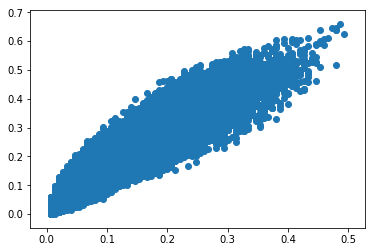

In [85]:
plt.scatter(Real_shifts['T19_Jaccard'], Real_shifts['T19_NDCG'])

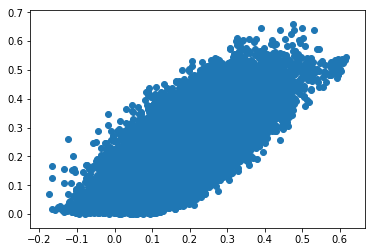

In [86]:
plt.scatter(Real_shifts['T19_Kendall'], Real_shifts['T19_NDCG'])